### apriltags and poses 20250116 CJH
* intended to teach the basics of apriltags and pose updates
* using https://www.chiefdelphi.com/t/wpilib-apriltagdetector-sample-code/421411/44?page=3 as a template for the geometry

In [1]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import matplotlib.pyplot as plt  # you always need matplotlib
import cv2
import numpy as np
import pandas as pd
import wpimath.geometry as geo
from wpimath import objectToRobotPose
import time

#### get yourself a layout of tags you can query for poses

In [2]:
# this is how you load in a layout - different in 2025 from 2024
field = ra.AprilTagField.k2025ReefscapeWelded
# layout = ra.loadAprilTagLayoutField(field=field)  # old way
layout = ra.AprilTagFieldLayout.loadField(field)

In [3]:
# example calls
tag = layout.getTags()[0]
tag.pose.x, tag.pose.translation(), tag.pose.rotation()

(16.697198,
 Translation3d(x=16.697198, y=0.655320, z=1.485900),
 Rotation3d(x=0.000000, y=0.000000, z=2.199115))

In [4]:
tag.pose, tag.pose.toPose2d()

(Pose3d(Translation3d(x=16.697198, y=0.655320, z=1.485900), Rotation3d(x=0.000000, y=0.000000, z=2.199115)),
 Pose2d(Translation2d(x=16.697198, y=0.655320), Rotation2d(2.199115)))

In [7]:
# let's see them all - remember rotations are in radians, 0 faces to the right, CCW is positive, so #6 is at -pi/2
tag_layout = {} 
for tag in layout.getTags():
    # print (f'ID:{tag.ID:02d}  pose: {tag.pose}')
    tag_layout.update({tag.ID:{'ID':tag.ID, 'X':tag.pose.x, 'Y':tag.pose.y, 'Z':tag.pose.z, 
                              'X_ROT':tag.pose.rotation().x, 'Y_ROT':tag.pose.rotation().x, 
                               'Z_ROT':tag.pose.rotation().z, 'Z_DEG':tag.pose.rotation().z*180/3.1459,}})
df = pd.DataFrame(tag_layout).transpose()
df

,ID,X,Y,Z,X_ROT,Y_ROT,Z_ROT,Z_DEG
1,1.0,16.697198,0.655320,1.485900,0.0,0.0,2.199115,125.827482
2,2.0,16.697198,7.396480,1.485900,0.0,0.0,-2.199115,-125.827482
3,3.0,11.560810,8.055610,1.301750,0.0,0.0,-1.570796,-89.876773
4,4.0,9.276080,6.137656,1.867916,0.0,0.0,0.000000,0.000000
5,5.0,9.276080,1.914906,1.867916,0.0,0.0,0.000000,0.000000
6,6.0,13.474446,3.306318,0.308102,0.0,0.0,-1.047198,-59.917848
7,7.0,13.890498,4.025900,0.308102,0.0,0.0,0.000000,0.000000
8,8.0,13.474446,4.745482,0.308102,0.0,0.0,1.047198,59.917848
9,9.0,12.643358,4.745482,0.308102,0.0,0.0,2.094395,119.835697
10,10.0,12.227306,4.025900,0.308102,0.0,0.0,3.141593,179.753545


#### plot of the apriltag locations in reefscape 

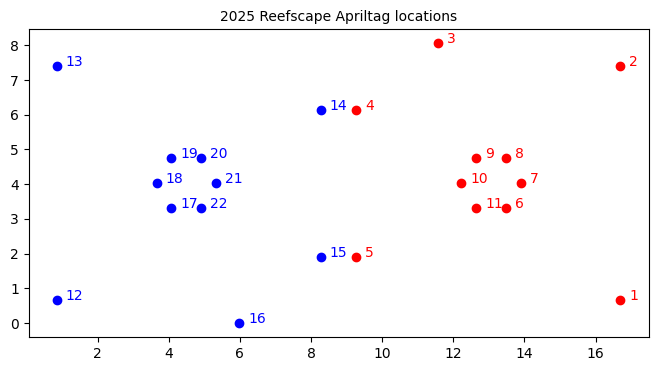

In [10]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (8,4))
for field_tag in layout.getTags():
    color = 'r' if field_tag.ID < 12 else 'b'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
ax.set_title('2025 Reefscape Apriltag locations', fontsize=10);

In [11]:
# if you want a tag's pose, just ask for it by ID
layout.getTagPose(6)

Pose3d(Translation3d(x=13.474446, y=3.306318, z=0.308102), Rotation3d(x=0.000000, y=-0.000000, z=-1.047198))

#### set up an apriltag detector and a pose estimator

In [12]:
# set up an apriltag detector
camera = 'arducam'
detector = ra.AprilTagDetector()
qt = detector.getQuadThresholdParameters()
qt.minClusterPixels = 10
detector.setQuadThresholdParameters(qt)

f = detector.addFamily('tag36h11')
print(f)
# need to calculate this based on camera and resolution
if camera == 'lifecam':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1651, fx=342.3, fy=335.1, cx=320/2, cy=240/2)
elif camera == 'c920':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1651, fx=439.5, fy=439.9, cx=640/2, cy=360/2) # logitech at 640x360
elif camera == 'arducam':
    config = ra.AprilTagPoseEstimator.Config(tagSize=0.1651, fx=563.95, fy=564.05, cx=315.83, cy=214.20) # arducam
else:
    raise ValueError('invalid camera')
estimator = ra.AprilTagPoseEstimator(config)  # 6 inches is 0.15m

True


#### read an image and extract the pose from the camera to the tag

In [14]:
image = cv2.imread('cal_images/arducam_648_480_03-06-2025_01.jpg', cv2.COLOR_RGB2BGR)
grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [15]:
print(grey_image.min(), grey_image.max())
print(grey_image.shape)

21 254
(480, 640)


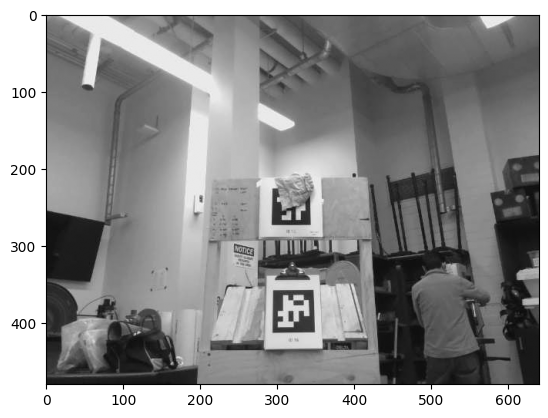

In [16]:
plt.imshow(grey_image, cmap='gray')

#### struggle but finally figure out how to modify a detector Config and QuadThresholdParameters

In [17]:
cfg = detector.getConfig()
properties = ['debug', 'decodeSharpening',  'numThreads',  'quadDecimate',  'quadSigma',  'refineEdges']
for prop in properties:
    value = getattr(cfg, prop)  # Or: value = cfg.prop (if you know it exists)
    print(f"{prop}: {value}")

debug: False
decodeSharpening: 0.25
numThreads: 1
quadDecimate: 2.0
quadSigma: 0.0
refineEdges: True


In [18]:
qt = detector.getQuadThresholdParameters()
properties = ['criticalAngle',
 'deglitch',
 'maxLineFitMSE',
 'maxNumMaxima',
 'minClusterPixels',
 'minWhiteBlackDiff']
for prop in properties:
    value = getattr(qt, prop)  # Or: value = cfg.prop (if you know it exists)
    print(f"{prop}: {value}")

criticalAngle: 0.7853981633974483
deglitch: False
maxLineFitMSE: 10.0
maxNumMaxima: 10
minClusterPixels: 10
minWhiteBlackDiff: 5


In [19]:
cfg.numThreads = 8  # can give a big speed up
cfg.debug = False  # how does this give me more info?
cfg.quadDecimate = 1  # big speed and detection effect - i think 0 and one are off, then about a 4x speed up if you go to 4 but you lose tags
cfg.decodeSharpening = 1  # drops the margin as this goes down
cfg.quadSigma = 0
cfg.refineEdges = True
detector.setConfig(cfg)

In [20]:
start_time = time.time()
iterations = 100
for i in range(iterations):
    tags = detector.detect(grey_image, )
end_time = time.time()
print(f'detections took {1000*(end_time-start_time)/iterations:.1f} ms each')
# tags = [tag for tag in tags if tag.getHamming()< 2 and tag.getDecisionMargin() > 20]
tags

detections took 6.4 ms each


[<AprilTagDetection tag_family=tag36h11 tag_id=16 hamming=0 decision_margin=317.6654357910156 center=AprilTagDetection.Point(x=321.37664926073404, y=384.95105462543387)>]

In [21]:
# not much I can do with this matrix
print(tags[0].getHomography())

(27.138139768499116, -7.731045924415122, 321.37664926073404, 0.09655534719928151, 18.087349609303658, 384.95105462543387, 0.0008112410599235464, -0.024707058198834238, 1.0)


#### if you want the ambiguity (and you do!) you have to use estimateOrthogonalIteration instead of estimate

In [22]:
at_poses = [estimator.estimateOrthogonalIteration(tag, 50) for tag in tags]

In [23]:
dmesg = ''
for tag, at_pose in zip(tags, at_poses):
    msg = f'ID {tag.getId():2d} ambiguity: {at_pose.getAmbiguity()}' + '\n' + f'{at_pose.pose1}' + '\n' + f'{at_pose.pose2}:'
    for d in ['x','y','z']:
        d = np.degrees (getattr(at_pose.pose1.rotation(), d) - getattr(at_pose.pose2.rotation(), d))
        dmesg = dmesg + f'{d:.2f} '
    print(msg)
    #print(dmesg)

ID 16 ambiguity: 0.0
Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-0.526754, y=-0.009244, z=-0.001745))
Transform3d(Translation3d(x=0.000000, y=0.000000, z=0.000000), Rotation3d(x=0.000000, y=0.000000, z=0.000000)):


In [24]:
poses = [estimator.estimate(tag) for tag in tags]

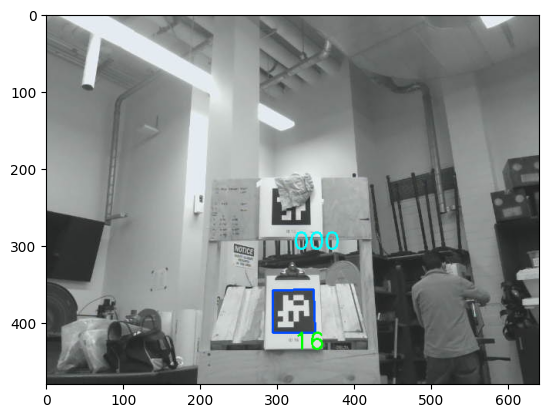

In [25]:
# see that we have the right one, and show the ambiguity
cvimage = image.copy()
for tag in tags:
    color = (255, 75, 0) if tag.getId() in [1, 2, 6, 7, 8, 14, 15, 16] else (0, 0, 255)  # blue and red tags - opencv is BGR
    center = tag.getCenter()
    center = [int(center.x), int(center.y)]
    corners = np.array(tag.getCorners([0] * 8)).reshape((-1, 1, 2)).astype(dtype=np.int32)
    cvimage = cv2.polylines(cvimage, [corners], isClosed=True, color=color, thickness=2)

    a = estimator.estimateOrthogonalIteration(tag, 50).getAmbiguity()
    cvimage = cv2.putText(cvimage, f'{int(1000*a):03d}', (center[0], center[1]-80), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
    cvimage = cv2.putText(cvimage, f'{tag.getId():2d}', (center[0], center[1]+50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
plt.imshow(cv2.cvtColor(cvimage, cv2.COLOR_BGR2RGB))

#### this is the pose of the camera relative to the tag - need to experiment a bit with positions to get it
* x (is negative if camera on right? or is this because we're twisted too?) - like a strafe 
* y is negative (because camera is below the tag?) - like a relative height
* z is distance so we should always be positive there 

In [93]:
pose = poses[0]
pose

Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-0.526754, y=-0.009244, z=-0.001745))

#### now we have to do some transforms to get the field pose of the camera, robot, and the tag

In [94]:
# camera is facing the tag, so we have to flip some things
pose_camera = geo.Transform3d(
    geo.Translation3d(pose.x, pose.y, pose.z),
    geo.Rotation3d(-pose.rotation().x -np.pi, -pose.rotation().y, pose.rotation().z - np.pi)
)

In [95]:
pose, pose_camera

(Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-0.526754, y=-0.009244, z=-0.001745)),
 Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-2.614839, y=0.009244, z=3.139848)))

In [96]:
# OpenCV and WPILib estimator layout of axes is EDN and field WPILib is NWU; need x -> -y , y -> -z , z -> x and same for differential rotations
pose_nwu = geo.CoordinateSystem.convert(pose_camera, geo.CoordinateSystem.EDN(), geo.CoordinateSystem.NWU())
print(pose_nwu)
# this may be buggy, according to OP, so try 
old = geo.CoordinateSystem.EDN()
new = geo.CoordinateSystem.NWU()
pose_nwu2 = geo.Transform3d(
    geo.CoordinateSystem.convert(pose_camera.translation(), old, new),
    geo.CoordinateSystem.convert(geo.Rotation3d(), new, old) + (geo.CoordinateSystem.convert(pose_camera.rotation(), old, new)),
)
print(pose_nwu2)
# nope - they both give the same answer

Transform3d(Translation3d(x=1.723371, y=-0.016927, z=-0.521748), Rotation3d(x=0.002018, y=-0.526769, z=-3.133364))
Transform3d(Translation3d(x=1.723371, y=-0.016927, z=-0.521748), Rotation3d(x=0.002018, y=-0.526769, z=-3.133364))


### apparently you don't need to provide a z offset to the CAMERA IN ROBOT FRAME - it solves for it
* it completely screws up the calculation?
* the tag is telling you how high you are, apparently
* the angles here are roll (x), pitch (y) and yaw (z).  we never roll the camera unless we put it sideways or upside down.
* but we usually pitch the camera - so that should always be in y, and negative is up
* rotation in z (yaw) directly changes the final pose rotation - it is the one that matters most!  
* however, there are some subtleties:
  * you need to provide the x and y offsets
  * it seems like you need combinations of x and y rotations to change things, so don't do that
  * if you add a z offset, it will change x, y and z by having the root sum of squares of their deltas = of the total z change
    * and it's completely linear
    * but it seems to do the same thing with x and y offsets - is it supposed to?
    * probably, because they don't actually change the 2D pose 

In [259]:
# camera pointing forwards on robot, at front and 6" off the ground  EDIT _ DO NOT MOVE OFF THE GROUND !!!
camera_in_robot_frame = geo.Transform3d(geo.Translation3d(0.2, 0, 0.15), geo.Rotation3d(0, 0, 0))
camera_in_robot_frame = geo.Transform3d(geo.Translation3d(0, 0, 0), geo.Rotation3d(np.radians(0), np.radians(-25), np.radians(0)))
camera_in_robot_frame

Transform3d(Translation3d(x=0.000000, y=0.000000, z=0.000000), Rotation3d(x=0.000000, y=-0.436332, z=0.000000))

In [260]:
tag_in_field_frame = layout.getTagPose(tag.getId())
# tag_in_field_frame = layout.getTagPose(1)  # can play with where the robot shows up if you change this number

In [261]:
robot_in_field_frame = objectToRobotPose(tag_in_field_frame,  pose_nwu2,  camera_in_robot_frame);
robot_in_field_frame

Pose3d(Translation3d(x=6.019488, y=1.748068, z=0.886517), Rotation3d(x=0.006180, y=-0.090406, z=-1.578468))

In [262]:
robot_field_position = robot_in_field_frame.toPose2d()
robot_field_position, robot_field_position.rotation().degrees()

(Pose2d(Translation2d(x=6.019488, y=1.748068), Rotation2d(-1.578468)),
 -90.43954753238548)

In [263]:
print(f'pose: {pose}\npose_camera: {pose_camera}\npose_nwu: {pose_nwu}\ntag_in_field_frame: {tag_in_field_frame}\nrobot_in_field_frame: {robot_in_field_frame}')
print(f'robot field position: {robot_field_position}\nrotation: {robot_field_position.rotation().degrees():.2f}')

pose: Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-0.526754, y=-0.009244, z=-0.001745))
pose_camera: Transform3d(Translation3d(x=0.016927, y=0.521748, z=1.723371), Rotation3d(x=-2.614839, y=0.009244, z=3.139848))
pose_nwu: Transform3d(Translation3d(x=1.723371, y=-0.016927, z=-0.521748), Rotation3d(x=0.002018, y=-0.526769, z=-3.133364))
tag_in_field_frame: Pose3d(Translation3d(x=5.987542, y=-0.003810, z=1.301750), Rotation3d(x=0.000000, y=0.000000, z=1.570796))
robot_in_field_frame: Pose3d(Translation3d(x=6.019488, y=1.748068, z=0.886517), Rotation3d(x=0.006180, y=-0.090406, z=-1.578468))
robot field position: Pose2d(Translation2d(x=6.019488, y=1.748068), Rotation2d(-1.578468))
rotation: -90.44


### try to plot the changes in pose as we change certain variables
#### you do not get all of your x or y offset if you don't have the correct y tilt
  * the error gets pushed into Z and then that makes your y offset too small

 dtx: -0.01 dty: -1.00 dtz: 0.00 sum: 1.00 
 dfx: -0.01 dfy: -1.00 


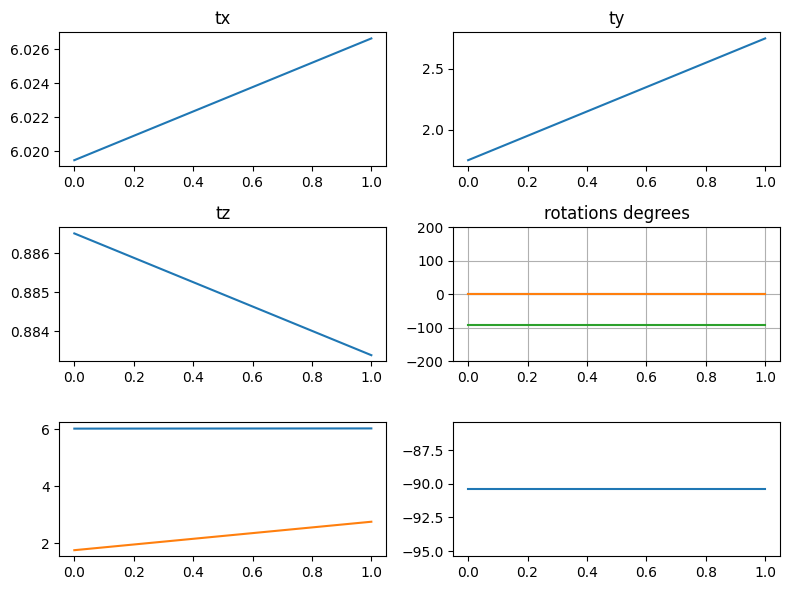

In [266]:
# all in one step - feed it a pose and get a 
def calculate_field_pose(pose, tag_id, val):
    # camera has to face the other way
    pose_camera = geo.Transform3d(geo.Translation3d(pose.x, pose.y, pose.z),
                                    geo.Rotation3d(-pose.rotation().x -np.pi, -pose.rotation().y, pose.rotation().z - np.pi))
    # convert from tagdetector coordinate system to WPI (I think)
    pose_nwu = geo.CoordinateSystem.convert(pose_camera, geo.CoordinateSystem.EDN(), geo.CoordinateSystem.NWU())
    # get the robot in the field
    tag_in_field_frame = layout.getTagPose(tag_id)
    camera_in_robot_frame = geo.Transform3d(geo.Translation3d(val, 0, 0), geo.Rotation3d(np.radians(0), np.radians(-30), np.radians(0)))
    robot_in_field_frame = objectToRobotPose(tag_in_field_frame,  pose_nwu2,  camera_in_robot_frame);
    robot_field_position = robot_in_field_frame.toPose2d()
    return robot_in_field_frame

fig, axs = plt.subplots(3,2,figsize = (8,6))
tx, ty, tz, rx, ry, rz, fx, fy, ft = [[] for _ in range(9)]
# Pose3d(Translation3d(x=6.019488, y=1.748068, z=0.886517), Rotation3d(x=0.532869, y=-0.144549, z=3.046148))
variable = np.linspace (0, 1, 100)
for v in variable:
    rff = calculate_field_pose(pose, 16, v)
    rfp = rff.toPose2d()
    fx.append(rfp.translation().x)
    fy.append(rfp.translation().y)
    ft.append(rfp.rotation().degrees())
    tx.append(rff.translation().x)
    ty.append(rff.translation().y)
    tz.append(rff.translation().z)
    rx.append(np.degrees(rff.rotation().x))
    ry.append(np.degrees(rff.rotation().y))
    rz.append(np.degrees(rff.rotation().z))
for idx, (ax, data, label) in enumerate(zip(axs.flatten(), [tx, ty, tz, rz], ['tx', 'ty', 'tz', 'rotations degrees', 'ry degrees', 'rz degrees'])):
    ax.set_title(f'{label}')
    if idx> 2:
        ax.set_ylim(-200,200)
        ax.grid('on')
        ax.plot(variable,rx)
        ax.plot(variable,ry)
        ax.plot(variable,rz)
    else:
        ax.plot(variable,data)

axs.flatten()[-2].plot(variable,fx, label='fieldx')
axs.flatten()[-2].plot(variable,fy, label='fieldy')
axs.flatten()[-1].plot(variable,ft, label='fieldt')
        

fig.tight_layout()
dtx, dty, dtz, dfx, dfy = tx[0]-tx[-1], ty[0]-ty[-1], tz[0]-tz[-1], fx[0]-fx[-1], fy[0]-fy[-1]

print(f' dtx: {dtx:.2f} dty: {dty:.2f} dtz: {dtz:.2f} sum: {np.sqrt(dtx**2+dty**2+dtz**2):.2f} ')
print(f' dfx: {dfx:.2f} dfy: {dfy:.2f} ')

#### now plot where the robot is on the field based on the tag
* note matplotlib and the pose have different definitions of zero

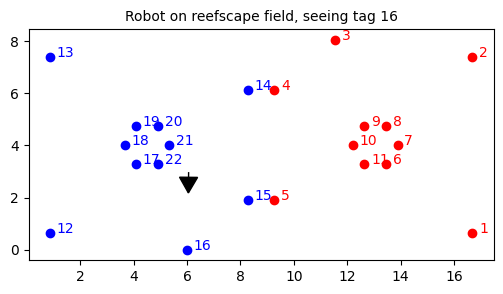

In [121]:
# make a quick plot of the locations of each tag
fig, ax = plt.subplots(1,1,figsize = (6,3))
for field_tag in layout.getTags():
    color = 'r' if field_tag.ID < 12 else 'b'
    ax.scatter(field_tag.pose.x, field_tag.pose.y, c=color)
    ax.text(field_tag.pose.x + 0.25, field_tag.pose.y, str(field_tag.ID), c=color)
# show the robot as a triangle - looks like CCW is positive
rotation = -90 + np.rad2deg(robot_in_field_frame.rotation().z)  # matplotlib angle of the triangle is 0 up, robot is 0 right
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(3, 0, rotation), color='k', markersize=15, linestyle='None')
ax.plot(robot_in_field_frame.x, robot_in_field_frame.y, marker=(2, 0, rotation), color='k', markersize=15, linestyle='None')
ax.set_title(f'Robot on reefscape field, seeing tag {tag.getId()}', fontsize=10);

In [38]:
# mucking about with compression
# compression = 1
# fig, axs = plt.subplots(1,2,figsize=(12,6))
# axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# axs[0].set_title(f'original image: {image.size}')
# ret, im_compressed = cv2.imencode('.jpg', image, [cv2.IMWRITE_JPEG_QUALITY, 10])
# axs[1].imshow(cv2.cvtColor(cv2.imdecode(im_compressed, 1),cv2.COLOR_BGR2RGB))
# axs[1].set_title(f'compressed image: {im_compressed.size}')

#### find the closest stage (or whatever)

In [39]:
import robotpy_apriltag as ra  # this comes with the robotpy package, you may need to add apriltags to the project.toml and sync to get it
import wpimath.geometry as geo

In [159]:
# this is how you load in a layout
field = ra.AprilTagField.k2025ReefscapeWelded
layout = layout = ra.AprilTagFieldLayout.loadField(field)

In [160]:
# make up a pose - irl would be the pose of the robot
x = 15
y = 6
my_location = geo.Pose2d(geo.Translation2d(x,y), geo.Rotation2d(0))

In [161]:
# get the tags
stage_tags = [11,12,15,16]
stage_poses = [layout.getTagPose(tag).toPose2d() for tag in stage_tags]

In [162]:
# find the tag distances
distances = [my_location.translation().distance(pose.translation()) for pose in stage_poses]
distances

[3.5790619208513292, 15.124663547798875, 7.870852370030835, 10.829133562656986]

In [163]:
# sort the tags based on the distances to them
combined = list(zip(stage_tags, distances))
combined.sort(key=lambda x: x[1])
sorted_tags, sorted_distances = zip(*combined)
print("Sorted tags:", sorted_tags)
print("Sorted distances:", sorted_distances)

Sorted tags: (11, 15, 16, 12)
Sorted distances: (3.5790619208513292, 7.870852370030835, 10.829133562656986, 15.124663547798875)


In [164]:
# winner is sorted_tags[0]
sorted_tags[0]

11